In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import re
import numpy as np
import random

In [2]:
# Folder setup
train_dir = 'train'
test_dir = 'test'

# Natural sort helper
def natural_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Image loader
def load_images_from_folder(folder, limit=None):
    images = []
    filenames = []
    count = 0
    for filename in sorted(os.listdir(folder), key=natural_key):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                images.append(img)
                filenames.append(filename)
                count += 1
                if limit and count >= limit:
                    break
    return images, filenames

In [3]:
# Hough line removal
def remove_lines_with_hough_enhanced(gray_img, binary_img):
    equalized = cv2.equalizeHist(gray_img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    enhanced = cv2.morphologyEx(equalized, cv2.MORPH_CLOSE, kernel)
    edges = cv2.Canny(enhanced, 30, 120)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=25, minLineLength=20, maxLineGap=10)
    cleaned = binary_img.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
            if 10 < abs(angle) < 170:
                cv2.line(cleaned, (x1, y1), (x2, y2), 255, 2)
    return cleaned

#  Morphological scratch line removal 
def remove_scratch_lines_morphological(binary_img):
    h_kernel = np.ones((1, 3), np.uint8)
    v_kernel = np.ones((3, 1), np.uint8)
    s_kernel = np.ones((2, 2), np.uint8)
    
    h_opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, h_kernel)
    v_opening = cv2.morphologyEx(h_opening, cv2.MORPH_OPEN, v_kernel)
    cleaned = cv2.morphologyEx(v_opening, cv2.MORPH_OPEN, s_kernel)

    closing_kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, closing_kernel)
    
    return cleaned

# Combined approach
def remove_scratch_lines_combined(gray_img, binary_img):
    hough_cleaned = remove_lines_with_hough_enhanced(gray_img, binary_img)
    morph_cleaned = remove_scratch_lines_morphological(hough_cleaned)
    return morph_cleaned

In [4]:
def safe_color_threshold(color, threshold=30):
    """
    Safely compute color thresholds while preventing integer overflow
    
    Parameters:
    color (numpy.ndarray): RGB color values
    threshold (int): Range of color variation to include
    
    Returns:
    tuple: Lower and upper color bounds
    """
    # Convert to unsigned 8-bit integer to prevent overflow
    color_u8 = color.astype(np.uint8)
    
    # Compute lower and upper bounds
    lower_bound = np.maximum(color_u8.astype(np.int16) - threshold, 0).astype(np.uint8)
    upper_bound = np.minimum(color_u8.astype(np.int16) + threshold, 255).astype(np.uint8)
    
    return lower_bound, upper_bound

In [5]:
def separate_overlapping_characters(img, color_threshold_percent=5):
    # Flatten the image and count color frequencies
    pixels = img.reshape(-1, 3)
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    
    # Calculate percentage of each color
    total_pixels = pixels.shape[0]
    color_percentages = counts / total_pixels * 100
    
    # Select colors that appear in at least 10% of the image
    significant_colors = unique_colors[color_percentages >= color_threshold_percent]
    white = np.array([255, 255, 255])
    significant_colors = significant_colors[~np.all(significant_colors == white, axis=1)]
    
    # Create masks for each significant color with color thresholding
    masks = []
    for color in significant_colors:
        # Define color threshold (to include similar shades)
        lower_bound, upper_bound = safe_color_threshold(color)
        # Create mask
        mask = cv2.inRange(img, lower_bound, upper_bound)

        masks.append(mask)
    
    # Sort masks by leftmost pixel
    def get_leftmost_pixel(mask):
        # Find non-zero coordinates
        coords = np.column_stack(np.where(mask > 0))
        return coords[:, 1].min() if coords.size > 0 else float('inf')
    
    sorted_masks = sorted(masks, key=get_leftmost_pixel)
    
    # Extract individual character images with white background
    character_images = []
    for mask in sorted_masks:
        # Create a white background image
        white_background = np.ones_like(img) * 255
        
        # Copy the character onto the white background using the mask
        character = white_background.copy()
        character[mask > 0] = img[mask > 0]
        
        character_images.append(character)
    
    return character_images

In [6]:
def get_letters(binary, color_img, color=False, min_area=50):
    binary_flipped = cv2.bitwise_not(binary)

    # Step 4: Find contours (external only)
    contours, _ = cv2.findContours(binary_flipped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Extract and filter bounding boxes
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h >= min_area:
            boxes.append((x, y, w, h))

    # Step 6: Sort boxes left to right
    boxes = sorted(boxes, key=lambda b: b[0])

    # Step 7: Crop characters
    letters = []
    for (x, y, w, h) in boxes:
        if color:
            char_img = color_img[y:y+h, x:x+w]
            separated = separate_overlapping_characters(char_img)
            for separated_img in separated:
                gray = cv2.cvtColor(separated_img, cv2.COLOR_BGR2GRAY)
                binary = cv2.adaptiveThreshold(
                        gray, 255,
                        cv2.ADAPTIVE_THRESH_MEAN_C,
                        cv2.THRESH_BINARY,
                        blockSize=15,
                        C=3
                    )
                letters.append(binary)
            
        else:
            char_img = binary[y:y+h, x:x+w]
            letters.append(char_img)

    return letters

In [7]:
# Preprocessing pipeline
def preprocess_image(img, resize_to=None, color=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        blockSize=15,
        C=3
    )

    cleaned = remove_scratch_lines_combined(gray, binary)
    
    mask = cv2.bitwise_not(cleaned)
    white_background = np.ones_like(img) * 255
    color_cleaned = white_background.copy()
    color_cleaned[mask > 0] = img[mask > 0]
    
    letters = get_letters(cleaned, color_cleaned, color=color)
    
    
    if resize_to:
        results = []
        for letter in letters:
            letter = cv2.resize(letter, resize_to)
            results.append(letter)
    
        return results
    else:
        return letters
    
    # return gray, binary, cleaned, color_cleaned
    

In [8]:
def rotate_image(img, angle):
    # Get image center and rotation matrix
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate bounding box size to fit rotated image
    cos = np.abs(rot_matrix[0, 0])
    sin = np.abs(rot_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix for translation
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]

    # Perform rotation with white background
    if len(img.shape) == 2:
        border_value = 255
    else:
        border_value = (255, 255, 255)

    rotated = cv2.warpAffine(img, rot_matrix, (new_w, new_h), borderValue=border_value)

    return rotated

In [9]:
train_letter_dir = 'train_letter'

In [10]:
angles = [-30, -20, -10, 10, 20, 30]

In [11]:
from collections import defaultdict
filename_count = defaultdict(int)

In [12]:
from PIL import Image
import numpy as np
import os

def save_image_from_array(img_array, save_path):
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        # Convert BGR (OpenCV) to RGB (PIL)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    img = Image.fromarray(img_array.astype(np.uint8))
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img.save(save_path)

In [13]:
def generate_char_dataset():
    count = 0
    miscount = 0
    for filename in sorted(os.listdir(train_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue

            label = filename.split('-')[0]
            chars = preprocess_image(img, resize_to=None, color=True)


            if len(label) != len(chars):
                miscount += 1

            for i in range(min(len(label), len(chars))):
                letter = label[i]
                char = chars[i]
                new_name = 'img-' + str(filename_count[letter]) + '.png'
                filename_count[letter] += 1
                save_image_from_array(char, os.path.join(train_letter_dir, letter, new_name))
                random_numbers = random.sample(range(len(angles)), 3)              
                for no in random_numbers:
                    new_char = rotate_image(char, angles[no])
                    new_name ='img-' + str(filename_count[letter]) + '.png'
                    filename_count[letter] += 1
                    save_image_from_array(new_char, os.path.join(train_letter_dir, letter, new_name))

        count += 1
        if count % 500 == 0:
            print(f"Done with {count} files")

    print(miscount)

# Run this cell to get the dataset

In [14]:
# generate_char_dataset()

In [15]:
img_path = "train/0axhfa-0.png"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

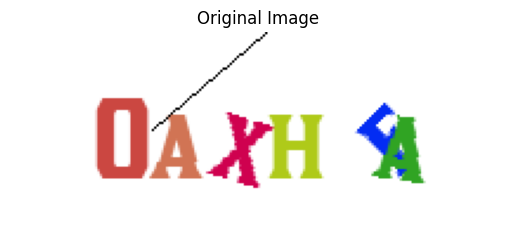

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis('off')
plt.title("Original Image")
plt.show()

In [17]:
r = preprocess_image(img, color=True)

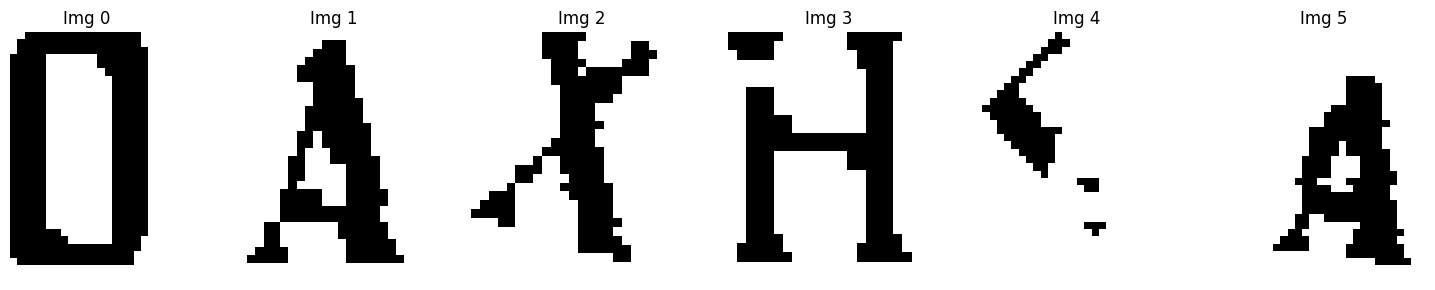

In [18]:
plt.figure(figsize=(15, 3))  # Adjust size as needed

for i, img in enumerate(r):
    plt.subplot(1, len(r), i + 1)
    # If using OpenCV images (BGR), convert to RGB
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Img {i}')

plt.tight_layout()
plt.show()